In [1]:
import os
import sys
import time
from typing import List, Optional

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import GroupKFold
from contextlib import contextmanager
from enum import Enum
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
from numba import jit

%matplotlib inline

DATA_DIR = '../input'

USE_PRECOMPUTE_FEATURES = True
TRAIN_FULL = True
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
IS_1ST_STAGE = False
NN_VALID_TH = 0.19

ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 3
SHORTCUT_NN_IN_1ST_STAGE = False
GBDT_NUM_MODELS = 3
GBDT_LR = 0.02  # 0.1

@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')


class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3

    
def load_stock_data(stock_id, directory):
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', directory, f'stock_id={stock_id}'))
    
def load_data(stock_id, stem, block):
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

def load_book(stock_id, block=DataBlock.TRAIN):
    return load_data(stock_id, 'book', block)

def load_trade(stock_id, block=DataBlock.TRAIN):
    return load_data(stock_id, 'trade', block)


In [2]:
def in_colab() -> bool:
    return 'google.colab' in sys.modules

def in_kaggle() -> bool:
    return 'kaggle_web_client' in sys.modules

if in_colab():
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'train.csv'))
stock_ids = set(train['stock_id'])

## Feature Engineering

### Base Features

In [4]:
# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series: np.ndarray):
    return np.log(series).diff()

def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)

def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret


def make_book_feature(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    # Calculate wap balance
    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    # Calculate spread
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))
    
    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id
    
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_trade_feature(stock_id, block = DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    # Dict for aggregations
    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id
        
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_book_feature_v2(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        price_list = prices.loc[tid].values.flatten()
        price_diff = sorted(np.diff(sorted(set(price_list))))
        ticks[tid] = price_diff[0]
        
    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    #book['tick_size'] = book['time_id'].map(ticks)
    
    # https://www.kaggle.com/lucasmorin/volatility-maximum-likelihood-estimation/comments#1495387
    #book['log_wap'] = np.log(calc_wap1(book))
    #book['log_return'] = book.groupby('time_id')['log_wap'].diff()
    #book['dt'] = book.groupby('time_id')['seconds_in_bucket'].diff()
    #book['inv_dt'] = 1 / book['dt']
    #book['estimated_volatility'] = np.power(book['log_return'] / np.sqrt(book['dt']), 2)
    #agg = book.groupby('time_id')['estimated_volatility'].sum()
    #dst['book.estimated_volatility'] = dst['time_id'].map(agg)
    #dst['book.estimated_volatility'] = np.sqrt(dst['book.estimated_volatility'])

    #book['log_return_df2'] = book.groupby(['time_id'])['wap1'].apply(log_return_df2)
    #book['price_spread_tick'] = (book['ask_price1'] - book['bid_price1']) / book['tick_size']
    #agg = book.groupby('time_id')['inv_dt'].mean()
    #dst['book.inv_dt.mean'] = dst['time_id'].map(agg)

    return dst


def make_trade_feature_v2(stock_id, block = DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    # Dict for aggregations
    features = {
        'size':[np.mean],
        'order_count':[np.sum],
    }

    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id
        
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg

def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)
        
    return df

def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)
    #with timer('trades(v2)'):
    #    trades = Parallel(n_jobs=-1)(delayed(make_trade_feature_v2)(i, block) for i in stock_ids)
    #    trade_v2 = pd.concat(trades)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d
    #return pd.merge(d, trade_v2, on=['stock_id', 'time_id'], how='left')
    
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather(os.path.join(DATA_DIR, 'optiver-df2', 'features_v2.f'))
else:
    df = make_features(train, DataBlock.TRAIN)
    # v2
    df = make_features_v2(df, DataBlock.TRAIN)

df.to_feather('features_v2.f')

test = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'test.csv'))
if len(test) == 3:
    IS_1ST_STAGE = True

test_df = make_features(test, DataBlock.TEST)
test_df = make_features_v2(test_df, DataBlock.TEST)

print(df.shape)
print(test_df.shape)
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)

df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])
#df['book.log_return1.realized_volatility.sq'] = np.power(df['book.log_return1.realized_volatility'], 2)

[load feather]  5.974sec
[books]  1.197sec
[trades]  0.348sec
[extra features]  0.034sec
[books(v2)]  0.021sec
(428932, 216)
(3, 216)


### Nearest-Neighbor Features

In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale

N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, pivot, p, metric='minkowski', metric_params=None):
        nn = NearestNeighbors(n_neighbors=N_NEIGHBORS_MAX, p=p, metric=metric, metric_params=metric_params)
        nn.fit(pivot)
        self.distances, self.neighbors = nn.kneighbors(pivot, return_distance=True)

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size']
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']

    pivot = df_pv.pivot('time_id', 'stock_id', 'price')
    pivot = pivot.fillna(pivot.mean())
    pivot = pd.DataFrame(minmax_scale(pivot))
    
    k_neighbors_p2 = Neighbors(pivot, 2, metric='canberra')
    k_neighbors_p1 = Neighbors(pivot, 2, metric='mahalanobis', metric_params={'V':np.cov(pivot.values.T)})
    k_neighbors_stock = Neighbors(minmax_scale(pivot.transpose()), 1)

    pivot = df_pv.pivot('time_id', 'stock_id', 'vol')

    #pivot = pd.concat([df_pv.pivot('time_id', 'stock_id', 'vol'), df_pv.pivot('time_id', 'stock_id', 'trade.tau')], axis=1).copy()
    pivot = pivot.fillna(pivot.mean())
    pivot = pd.DataFrame(minmax_scale(pivot))
    
    k_neighbors_vol = Neighbors(pivot, 1)
    k_neighbors_stock_vol = Neighbors(minmax_scale(pivot.transpose()), 1)
    
    pivot = df_pv.pivot('time_id', 'stock_id', 'trade.size.sum')
    pivot = pivot.fillna(pivot.mean())
    pivot = pd.DataFrame(minmax_scale(pivot))
    k_neighbors_size = Neighbors(pivot, 2, metric='mahalanobis', metric_params={'V':np.cov(pivot.values.T)})
    k_neighbors_size_p2 = Neighbors(pivot, 2, metric='canberra')
    k_neighbors_stock_size = Neighbors(minmax_scale(pivot.transpose()), 1)


[knn fit]  410.567sec


In [6]:
def make_neighbors(df, k_neighbors, feature_col, n=5):
    feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
    feature_pivot = feature_pivot.fillna(feature_pivot.mean())
    feature_pivot.head()
    
    neighbors = np.zeros((n, *feature_pivot.shape))

    for i in range(n):
        neighbors[i, :, :] += feature_pivot.values[k_neighbors[:, i], :]
        
    return feature_pivot, neighbors

def make_neighbors_stock(df, k_neighbors, feature_col, n=5):
    feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
    feature_pivot = feature_pivot.fillna(feature_pivot.mean())
    feature_pivot.head()
    
    neighbors = np.zeros((n, *feature_pivot.shape))

    for i in range(n):
        neighbors[i, :, :] += feature_pivot.values[:, k_neighbors[:, i]]
        
    return feature_pivot, neighbors

def make_nn_feature(df, neighbors, columns, index, n=5, agg=np.mean, postfix='', exclude_self=False, exact=False):
    start = 1 if exclude_self else 0
    
    if exact:
        pivot_aggs = pd.DataFrame(neighbors[n-1,:,:], columns=columns, index=index)
    else:
        pivot_aggs = pd.DataFrame(agg(neighbors[start:n,:,:], axis=0), columns=columns, index=index)
    dst = pivot_aggs.unstack().reset_index()
    dst.columns = ['stock_id', 'time_id', f'{feature_col}_cluster{n}{postfix}_{agg.__name__}']
    return dst


In [7]:
import gc
from scipy.stats import rankdata

def rank_data(a, axis=None):
    return a[0] - np.min(a, axis=axis)

gc.collect()

df2 = df.copy()
print(df2.shape)

df2['real_price'] = 0.01 / df2['tick_size']
del df2['tick_size']

# relative rank
df2['trade.order_count.mean'] = df2.groupby('time_id')['trade.order_count.mean'].rank()
df2['book.total_volume.sum'] = df2.groupby('time_id')['book.total_volume.sum'].rank()
df2['book.total_volume.mean'] = df2.groupby('time_id')['book.total_volume.mean'].rank()
df2['book.total_volume.std'] = df2.groupby('time_id')['book.total_volume.std'].rank()

df2['trade.tau'] = df2.groupby('time_id')['trade.tau'].rank()

#df2['trade_300.tau'] = df2.groupby('time_id')['trade_300.tau'].rank()
#df2['book.total_volume.std'] = df2.groupby('time_id')['book.total_volume.std'].rank()
#df2['trade.size.sum'] = df2.groupby('time_id')['trade.size.sum'].rank()

for dt in [150, 300, 450]:
    df2[f'book_{dt}.total_volume.sum'] = df2.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
    df2[f'book_{dt}.total_volume.mean'] = df2.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
    df2[f'book_{dt}.total_volume.std'] = df2.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()
    df2[f'trade_{dt}.order_count.mean'] = df2.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()

#df2.groupby('time_id')['book.volume_imbalance.sum'].rank()
#df2['tick_size'] = df2.groupby('time_id')['tick_size'].rank()

feature_cols_stock = {
    'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],

    'trade.seconds_in_bucket.count': [np.mean],
    'trade.tau': [np.mean],
    'trade_150.tau': [np.mean],
    'book.tau': [np.mean],
    'trade.size.sum': [np.mean],
    'book.seconds_in_bucket.count': [np.mean],
    
    #'trade.order_count.mean': [np.mean],
    #'avg_time_vol': [np.mean],
    #'trade_150.tau': [np.mean],
    #'trade_450.tau': [np.mean],
    #'book.total_volume.sum': [np.mean],
    #'book.volume_imbalance.mean': [np.mean],
}
    
feature_cols = {
    'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
    #'book_150.log_return1.realized_volatility': [np.mean, np.min],
    #'book_300.log_return1.realized_volatility': [np.mean, np.min],
    #'book_450.log_return1.realized_volatility': [np.mean, np.min],
    
    'real_price': [np.max, np.mean, np.min],

    'trade.seconds_in_bucket.count': [np.mean],
    'trade.tau': [np.mean],
    'trade.size.sum': [np.mean],
    'book.seconds_in_bucket.count': [np.mean],
    
    'trade_150.tau_cluster20_sv_mean': [np.mean],  # "volatilityの傾向が似ている20銘柄での直前300secの平均tau" の、近い時刻での平均
    'trade.size.sum_cluster20_sv_mean': [np.mean],
    #'book.log_return1.realized_volatility.sq': [np.sum],
    #'book.estimated_volatility': [np.mean],
    #'trade.order_count.mean': [np.mean],
    #'book.total_volume.sum': [np.mean],
    #'book.volume_imbalance.mean': [np.mean],
    #'avg_time_vol': [np.mean],
    #'book.ask_spread.mean': [np.mean],
    #'book.bid_spread.mean': [np.mean],
}

time_id_neigbor_sizes = [3, 5, 10, 20, 40]
time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]
stock_id_neighbor_sizes = [10, 20, 40]

ndf = None

cols = []

def _add_ndf(ndf, dst):
    if ndf is None:
        return dst
    else:
        ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
        return ndf

# neighbor stock_id
for feature_col in feature_cols_stock.keys():
    feature_pivot, neighbors_stock = make_neighbors_stock(df2, k_neighbors_stock.neighbors, feature_col, n=N_NEIGHBORS_MAX)
    _, neighbors_stock_vol = make_neighbors_stock(df2, k_neighbors_stock_vol.neighbors, feature_col, n=N_NEIGHBORS_MAX)
    _, neighbors_stock_size = make_neighbors_stock(df2, k_neighbors_stock_size.neighbors, feature_col, n=N_NEIGHBORS_MAX)

    columns = feature_pivot.columns
    index = feature_pivot.index

    for agg in feature_cols_stock[feature_col]:
        for n in stock_id_neighbor_sizes:
            exclude_self = True
            exact = False
            dst = make_nn_feature(df2, neighbors_stock, columns, index, n=n, agg=agg, postfix='_s',
                                 exclude_self=exclude_self, exact=exact)
            ndf = _add_ndf(ndf, dst)
            dst = make_nn_feature(df2, neighbors_stock_vol, columns, index, n=n, agg=agg, postfix='_sv',
                                 exclude_self=exclude_self, exact=exact)
            ndf = _add_ndf(ndf, dst)
            #dst = make_nn_feature(df2, neighbors_stock_size, columns, index, n=n, agg=agg, postfix='_ssize',
            #                     exclude_self=exclude_self)
            #ndf = _add_ndf(ndf, dst)
    del feature_pivot, neighbors_stock, neighbors_stock_vol

df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')
ndf = None

# neighbor time_id
for feature_col in feature_cols.keys():
    feature_pivot, neighbors = make_neighbors(df2, k_neighbors_p2.neighbors, feature_col, n=N_NEIGHBORS_MAX)
    _, neighbors_p1 = make_neighbors(df2, k_neighbors_p1.neighbors, feature_col, n=N_NEIGHBORS_MAX)
    _, neighbors_vol = make_neighbors(df2, k_neighbors_vol.neighbors, feature_col, n=N_NEIGHBORS_MAX)
    _, neighbors_size = make_neighbors(df2, k_neighbors_size.neighbors, feature_col, n=N_NEIGHBORS_MAX)
    _, neighbors_size_p2 = make_neighbors(df2, k_neighbors_size_p2.neighbors, feature_col, n=N_NEIGHBORS_MAX)
    
    columns = feature_pivot.columns
    index = feature_pivot.index
    
    if 'volatility' in feature_col:
        time_id_ns = time_id_neigbor_sizes_vol
    else:
        time_id_ns = time_id_neigbor_sizes
 
    for agg in feature_cols[feature_col]:
        for n in time_id_ns:
            exclude_self = True #n >= 10
            exclude_self2 = False
            exact = False
            
            #if n <= 40:
            dst = make_nn_feature(df2, neighbors, columns, index, n=n, agg=agg, postfix='_p2',
                                  exclude_self=exclude_self, exact=exact)
            ndf = _add_ndf(ndf, dst)
            dst = make_nn_feature(df2, neighbors_p1, columns, index, n=n, agg=agg, postfix='_p1',
                                 exclude_self=exclude_self2, exact=exact)
            ndf = _add_ndf(ndf, dst)

            dst = make_nn_feature(df2, neighbors_vol, columns, index, n=n, agg=agg, postfix='_v',
                                 exclude_self=exclude_self2, exact=exact)
            ndf = _add_ndf(ndf, dst)
            dst = make_nn_feature(df2, neighbors_size, columns, index, n=n, agg=agg, postfix='_size',
                                 exclude_self=exclude_self2, exact=exact)
            ndf = _add_ndf(ndf, dst)
            dst = make_nn_feature(df2, neighbors_size_p2, columns, index, n=n, agg=agg, postfix='_size_p2',
                                 exclude_self=exclude_self2, exact=exact)
            ndf = _add_ndf(ndf, dst)
            cols.append(dst.columns[-1])
            
    del feature_pivot, neighbors, neighbors_p1, neighbors_vol, neighbors_size, neighbors_size_p2

df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')

# 株価そのものは特徴量に使わず、近傍のtime_idに対する相対評価のみ用いる

for sz in time_id_neigbor_sizes:
    df2[f'real_price_rankmin_{sz}'] = df2['real_price'] / df2[f"real_price_cluster{sz}_p2_amin"]
    df2[f'real_price_rankmax_{sz}'] = df2['real_price'] / df2[f"real_price_cluster{sz}_p2_amax"]
    df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"real_price_cluster{sz}_p2_mean"]

for sz in time_id_neigbor_sizes_vol:
    df2[f'vol_rankmin_{sz}'] = df2['book.log_return1.realized_volatility'] / df2[f"book.log_return1.realized_volatility_cluster{sz}_p2_amin"]
    df2[f'vol_rankmax_{sz}'] = df2['book.log_return1.realized_volatility'] / df2[f"book.log_return1.realized_volatility_cluster{sz}_p2_amax"]

price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
for c in price_cols:
    del df2[c]

#df2['book.log_return1.realized_volatility_rank'] = df2.groupby('time_id')['book.log_return1.realized_volatility'].rank()
#df2['book.log_return1.realized_volatility_cluster3_size_mean_rank'] = df2.groupby('time_id')['book.log_return1.realized_volatility_cluster3_size_mean'].rank()

for sz in time_id_neigbor_sizes_vol:
    tgt = f'book.log_return1.realized_volatility_cluster{sz}_p1_mean'
    df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    
    
# skew correction for NN
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
for c in df2.columns:
    for check in cols_to_log:
        if check in c:
            df2[c] = np.log(df2[c]+1)
            break

print(df2.shape)
df2.reset_index(drop=True).to_feather('optiver_df2.f')

del ndf

(428935, 219)
(428935, 581)


In [8]:
# 同じ銘柄で近い取引量の時のRVを平均する
df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
df2.reset_index(drop=True, inplace=True)
df2['realized_volatility_roll3_by_book.total_volume.mean'] = df2.groupby('stock_id')['book.log_return1.realized_volatility'].rolling(3, center=True, min_periods=1).mean().reset_index().sort_values(by=['level_1'])['book.log_return1.realized_volatility'].values
df2['realized_volatility_roll10_by_book.total_volume.mean'] = df2.groupby('stock_id')['book.log_return1.realized_volatility'].rolling(10, center=True, min_periods=1).mean().reset_index().sort_values(by=['level_1'])['book.log_return1.realized_volatility'].values


### Stock-id Embedding

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda_n = 3
lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)
stock_id_emb = pd.DataFrame(lda.fit_transform(pivot.transpose()), index=df_pv.pivot('time_id', 'stock_id', 'vol').columns)

for i in range(lda_n):
    df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])

In [10]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2
gc.collect()

108

## Make CV Split

In [11]:
import glob
import time
from contextlib import contextmanager

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    # AMZN
    plt.plot(dft['stock_id=61'])
    plt.plot(dft['stock_id=37'])
    plt.plot(dft['stock_id=113'])
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')
        df_target = pd.read_csv('/kaggle/input/optiver-realized-volatility-prediction/train.csv')
        df_target = df_target.groupby('time_id').target.mean()

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)
        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])
    
    return df_ordered[['time_id']]

In [12]:
with timer('calculate order of time-id'):
    if USE_PRECOMPUTE_FEATURES:
        timeid_order = pd.read_csv(os.path.join(DATA_DIR, 'optiver-time-id-ordered', 'time_id_order.csv'))
    else:
        timeid_order = reconstruct_time_id_order()

with timer('make folds'):
    timeid_order['time_id_order'] = np.arange(len(timeid_order))
    df_train['time_id_order'] = df_train['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
    df_train = df_train.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)

    folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
    time_id_orders = df_train['time_id_order']

    folds = []
    for i, border in enumerate(folds_border):
        idx_train = np.where(time_id_orders < border)[0]
        idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
        folds.append((idx_train, idx_valid))
        
        print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")
        
del df_train['time_id_order']

[calculate order of time-id] 0.018sec
folds0: train=257362, valid=42882
folds1: train=300244, valid=42896
folds2: train=343140, valid=42896
folds3: train=386036, valid=42896
[make folds] 1.841sec


In [13]:
if False:
    for dt in [3]:
        roll = df_train.groupby('stock_id')['real_price'].rolling(dt).mean().reset_index().sort_values(by=['level_1'])['real_price'].values
        df_train[f'real_price.back_mean_{dt}'] = roll10
        df_train[f'real_price.forward_mean_{dt}'] = df_train.groupby('stock_id')[f'real_price.back_mean_{dt}'].shift(-dt)
        df_train[f'real_price.back_mean_{dt}'] = df_train['real_price'] / df_train[f'real_price.back_mean_{dt}']
        df_train[f'real_price.back_forward_{dt}'] = df_train['real_price'] / df_train[f'real_price.forward_mean_{dt}']
        
    del df_train['real_price']

# 3/4foldで改善したが、fold1が大きく悪化。
#df_train['ratio1'] = df_train['trade.log_return.realized_volatility'] / df_train['book.log_return1.realized_volatility']
#df_train['ratio2'] = df_train['book.log_return1.realized_volatility_cluster3_p2_mean'] / df_train['book.log_return1.realized_volatility']
#df_train['ratio3'] = df_train['book.log_return1.realized_volatility_cluster3_p1_mean'] / df_train['book.log_return1.realized_volatility']
#df_train['ratio4'] = df_train['book_300.log_return1.realized_volatility'] / df_train['book.log_return1.realized_volatility']
#df_train['ratio5'] = df_train['book.log_return1.realized_volatility_cluster3_p2_mean'] / df_train['book.log_return1.realized_volatility_cluster10_p2_mean']
#df_train['ratio6'] = df_train['trade.tau'] / df_train['trade.tau_cluster3_p2_mean']

#df_train['ratio7'] = df_train['trade.size.sum'] / df_train['trade.size.sum_cluster3_p2_mean']
#df_train['ratio８'] = df_train['trade.size.sum'] / df_train['trade.size.sum_cluster5_p2_mean']

# ばらつき大.
#df_train['diff1'] = df_train['book.log_return1.realized_volatility'] - df_train['book.log_return1.realized_volatility_cluster3_p2_mean']
#df_train['diff2'] = df_train['book.log_return1.realized_volatility_cluster3_p1_mean'] - df_train['book.log_return1.realized_volatility_cluster3_p2_mean']


## LightGBM Training

(428932, 584)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.329472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.969350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.853365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.292484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[20]	cv_agg's l2: 7.38695e-07 + 1.60608e-07	cv_agg's RMSPE: 0.38011 + 0.0099775
[40]	cv_agg's l2: 4.52578e-07 + 8.38512e-08	cv_agg's RMSPE: 0.298445 + 0.00437991
[60]	cv_agg's l2: 3.23178e-07 + 5.03378e-08	cv_agg's RMSPE: 0.252918 + 0.00585063
[80]	cv_agg's l2: 2.63681e-07 + 3.6223e-08	cv_agg's RMSPE: 0.22891 + 0.00863284
[1

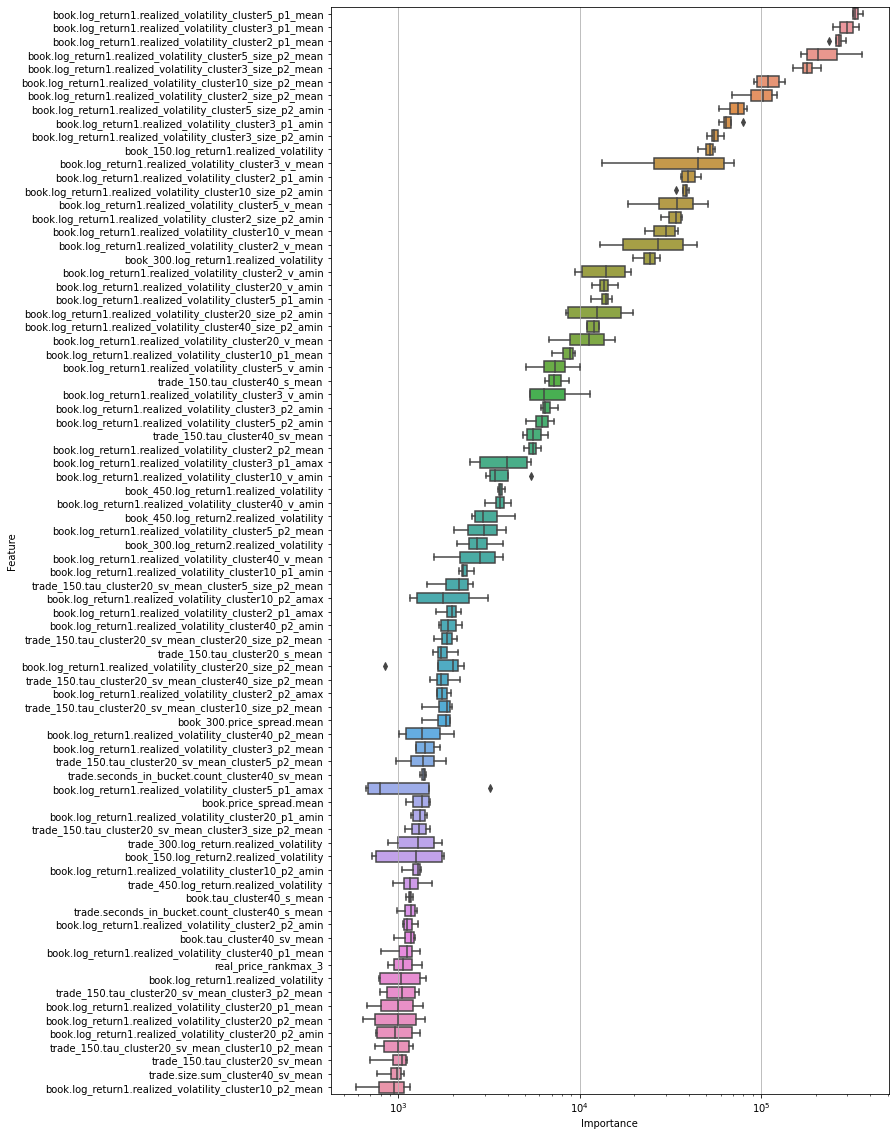

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.160897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.465395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.722458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[retraining] 1259.042sec


61312

In [14]:
import gc
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # 上位をプロットする
    PLOT_TOP_N = 80
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

lr = GBDT_LR
params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': lr
}

class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())

    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()

def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target']]
    return df_src[cols]

X = get_X(df_train)
y = df_train['target']
X.to_feather('X.f')
df_train[['target']].to_feather('y.f')

gc.collect()

print(X.shape)

if PREDICT_GBDT:
    ds = lgb.Dataset(X, y, weight=1/np.power(y, 2))

    with timer('lgb.cv'):
        ret = lgb.cv(params, ds, num_boost_round=8000, folds=folds, #cv,
                     feval=feval_RMSPE, stratified=False, 
                     return_cvbooster=True, verbose_eval=20,
                     early_stopping_rounds=int(40*0.1/lr))

        # current best: 0.204666 (cluster groupkfold)
        # current best: 0.20629 (time-series, 4folds, 10% valid)
        print(f"# overall RMSPE: {ret['RMSPE-mean'][-1]}")

    best_iteration = len(ret['RMSPE-mean'])
    for i in range(len(folds)):
        y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[folds[i][1]], num_iteration=best_iteration)
        y_true = y.iloc[folds[i][1]]
        print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")

    plot_importance(ret['cvbooster'], figsize=(10, 20))

    if TRAIN_FULL:
        boosters = []
        with timer('retraining'):
            for _ in range(GBDT_NUM_MODELS):
                boosters.append(lgb.train(params, ds, num_boost_round=int(1.1*best_iteration)))
                
        booster = EnsembleModel(boosters)
        del ret

    #del X, y, ds
    del ds

gc.collect()

#[20]	cv_agg's l2: 2.32685e-07 + 2.96471e-08	cv_agg's RMSPE: 0.215317 + 0.0105853
#[40]	cv_agg's l2: 2.07503e-07 + 2.60842e-08	cv_agg's RMSPE: 0.203468 + 0.0116355
#[60]	cv_agg's l2: 2.04544e-07 + 2.61008e-08	cv_agg's RMSPE: 0.201977 + 0.0113603
#[80]	cv_agg's l2: 2.03579e-07 + 2.59835e-08	cv_agg's RMSPE: 0.20149 + 0.0112293
#[100]	cv_agg's l2: 2.0297e-07 + 2.57662e-08	cv_agg's RMSPE: 0.201195 + 0.0111581
#[120]	cv_agg's l2: 2.02843e-07 + 2.58755e-08	cv_agg's RMSPE: 0.20112 + 0.0111222
#[140]	cv_agg's l2: 2.02751e-07 + 2.58503e-08	cv_agg's RMSPE: 0.201075 + 0.011069
#[160]	cv_agg's l2: 2.02773e-07 + 2.59782e-08	cv_agg's RMSPE: 0.201073 + 0.0110104
#[180]	cv_agg's l2: 2.02933e-07 + 2.6137e-08	cv_agg's RMSPE: 0.201148 + 0.0110521
# overall RMSPE: 0.201055
# fold0 RMSPE: 0.20412414796779355
# fold1 RMSPE: 0.2101286514142503
# fold2 RMSPE: 0.20769188046340817
# fold3 RMSPE: 0.1822814692175734

## NN Training

In [15]:
import gc
import os
import pickle
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted
from sklearn.decomposition import PCA

null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
]

class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module):
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'gauss':
            scaler = GaussRankScaler()
            X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=4)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())
                    
            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs

def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = -1,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []


    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=4)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, 
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=4)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")
            
            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader, X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()
        
    return best_losses, best_predictions, scaler


In [16]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                        X|1336552272|
|                       df| 646834140|
|                    df_pv|  20589040|
|                 df_train|1343415184|
|                      dst|  10303264|
|                    index|    162832|
|     neighbors_stock_size| 274749568|
|                    pivot|   3434528|
|           time_id_orders|   3431616|
|             timeid_order|     61440|
|                    train|  10294528|
|                        y|   3431616|
|                   y_pred|    343264|
|                   y_true|    686368|


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

del df, df_train
gc.collect()

if PREDICT_MLP:
    model_paths = []
    
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        epochs = 3
        valid_th = 100
    else:
        epochs = 30
        valid_th = NN_VALID_TH
    
    for i in range(NN_NUM_MODELS):
        # MLP
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                                 [folds[-1]], 
                                                 device=device, 
                                                 batch_size=512,
                                                 mlp_bn=True,
                                                 mlp_hidden=256,
                                                 mlp_dropout=0.0,
                                                 emb_dim=30,
                                                 epochs=epochs,
                                                 lr=0.002,
                                                 max_lr=0.0055,
                                                 weight_decay=1e-7,
                                                model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                                seed=i)
        print(nn_losses)
        if nn_losses[0] < NN_VALID_TH:
            print(f'model of seed {i} added.')
            model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
    mlp_model = [torch.load(path, device) for path in model_paths]
    
    print(f'total {len(mlp_model)} models will be used.')
if PREDICT_CNN:
    model_paths = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        epochs = 3
        valid_th = 100
    else:
        epochs = 50
        valid_th = NN_VALID_TH

    for i in range(NN_NUM_MODELS):
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               cnn_hidden=8*128,
                                                  batch_size=1280,
                                                  model_type='cnn',
                                                  emb_dim=30,
                                                  epochs=epochs, #epochs,
                                                  cnn_channel1=128,
                                                  cnn_channel2=3*128,
                                                  cnn_channel3=3*128,
                                                  lr=0.00038, #0.0011,
                                                  #scaler_type=scaler_type,
                                                  max_lr=0.0013,
                                                  weight_decay=6.5e-6,
                                                optimizer_type='adam',
                                               scheduler_type='reduce',
                                                model_path='cnn_fold_{}' + f"_seed{i}.pth",
                                                seed=i,
                                              cnn_dropout=0.0,
                                              cnn_weight_norm=True,
                                              cnn_leaky_relu=False,
                                              patience=8,
                                              factor=0.3)
        if nn_losses[0] < valid_th:
            model_paths.append(f'artifacts/cnn_fold_0_seed{i}.pth')
    cnn_model = [torch.load(path, device) for path in model_paths]
        
    print(f'total {len(cnn_model)} models will be used.')

cuda
fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 21.544, valid rmspe: 3.555
new best:3.5548722743988037


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 5.478, valid rmspe: 4.388


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.763, valid rmspe: 3.002
new best:3.0017120838165283


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 2.365, valid rmspe: 1.426
new best:1.4262170791625977


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 1.146, valid rmspe: 0.321
new best:0.32077842950820923


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.549, valid rmspe: 0.328


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.552, valid rmspe: 0.643


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.577, valid rmspe: 0.230
new best:0.23008973896503448


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.493, valid rmspe: 0.571


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.535, valid rmspe: 0.780


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.437, valid rmspe: 0.337


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.401, valid rmspe: 0.350


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.437, valid rmspe: 0.351


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.404, valid rmspe: 0.198
new best:0.19765082001686096


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.346, valid rmspe: 0.277


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.324, valid rmspe: 0.270


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.291, valid rmspe: 0.210


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.269, valid rmspe: 0.186
new best:0.1859540045261383


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.254, valid rmspe: 0.201


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.263, valid rmspe: 0.302


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.253, valid rmspe: 0.254


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.254, valid rmspe: 0.217


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.229, valid rmspe: 0.197


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.219, valid rmspe: 0.183
new best:0.1834007203578949


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.214, valid rmspe: 0.215


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.208, valid rmspe: 0.193


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.208, valid rmspe: 0.198


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.201, valid rmspe: 0.184


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.198, valid rmspe: 0.184


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.94it/s]


epoch 29, train loss: 0.197, valid rmspe: 0.183
new best:0.18260832130908966
[0.18260832]
model of seed 0 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 26.458, valid rmspe: 5.718
new best:5.71785831451416


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 7.088, valid rmspe: 2.920
new best:2.9196858406066895


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 4.277, valid rmspe: 1.276
new best:1.2764371633529663


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 1.603, valid rmspe: 0.818
new best:0.8175786137580872


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.745, valid rmspe: 1.012


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.758, valid rmspe: 0.421
new best:0.4210692346096039


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.551, valid rmspe: 0.854


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.634, valid rmspe: 0.309
new best:0.30856844782829285


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.549, valid rmspe: 0.411


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.307, valid rmspe: 0.202
new best:0.2017420083284378


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.454, valid rmspe: 0.348


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.376, valid rmspe: 0.229


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.399, valid rmspe: 0.206


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.321, valid rmspe: 0.463


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.312, valid rmspe: 0.222


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.303, valid rmspe: 0.219


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.273, valid rmspe: 0.246


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.289, valid rmspe: 0.219


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.281, valid rmspe: 0.201
new best:0.2005404531955719


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.248, valid rmspe: 0.194
new best:0.19405578076839447


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.249, valid rmspe: 0.191
new best:0.1905241459608078


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.233, valid rmspe: 0.185
new best:0.18480995297431946


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.224, valid rmspe: 0.205


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.222, valid rmspe: 0.234


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.209, valid rmspe: 0.186


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.213, valid rmspe: 0.205


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.203, valid rmspe: 0.190


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.201, valid rmspe: 0.188


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.198, valid rmspe: 0.182
new best:0.18223118782043457


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 67.96it/s]


epoch 29, train loss: 0.196, valid rmspe: 0.183
[0.18223119]
model of seed 1 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 22.422, valid rmspe: 6.694
new best:6.693961143493652


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 6.397, valid rmspe: 5.946
new best:5.945800304412842


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.125, valid rmspe: 2.184
new best:2.183828353881836


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 2.068, valid rmspe: 0.664
new best:0.6643406748771667


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.774, valid rmspe: 0.633
new best:0.6334158778190613


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.725, valid rmspe: 0.224
new best:0.22352604568004608


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.640, valid rmspe: 0.655


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.573, valid rmspe: 0.744


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.620, valid rmspe: 0.409


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.538, valid rmspe: 0.549


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.551, valid rmspe: 0.293


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.531, valid rmspe: 0.444


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.434, valid rmspe: 0.492


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.443, valid rmspe: 0.193
new best:0.1926783323287964


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.389, valid rmspe: 0.406


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.372, valid rmspe: 0.315


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.371, valid rmspe: 0.313


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.331, valid rmspe: 0.291


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.329, valid rmspe: 0.192
new best:0.19156382977962494


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.302, valid rmspe: 0.240


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.269, valid rmspe: 0.244


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.258, valid rmspe: 0.315


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.246, valid rmspe: 0.189
new best:0.18922364711761475


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.227, valid rmspe: 0.223


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.226, valid rmspe: 0.195


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.216, valid rmspe: 0.183
new best:0.18329356610774994


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.207, valid rmspe: 0.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.204, valid rmspe: 0.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.201, valid rmspe: 0.183
new best:0.18294598162174225


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 69.10it/s]


epoch 29, train loss: 0.200, valid rmspe: 0.183
[0.18294598]
model of seed 2 added.
total 3 models will be used.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 36.847, valid rmspe: 13.479
new best:13.479052543640137


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 6.999, valid rmspe: 11.602
new best:11.602226257324219


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 6.338, valid rmspe: 3.183
new best:3.1833648681640625


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 4.711, valid rmspe: 5.562


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 4.004, valid rmspe: 3.696


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 2.540, valid rmspe: 5.343


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.675, valid rmspe: 1.612
new best:1.6116986274719238


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 1.750, valid rmspe: 0.838
new best:0.8377463817596436


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 2.455, valid rmspe: 0.642
new best:0.6421473622322083


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.853, valid rmspe: 1.397


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.457, valid rmspe: 1.241


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 1.112, valid rmspe: 1.306


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.893, valid rmspe: 0.860


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 1.165, valid rmspe: 8.129


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.836, valid rmspe: 1.082


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.799, valid rmspe: 0.527
new best:0.5268535614013672


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.686, valid rmspe: 0.525
new best:0.5245238542556763


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.619, valid rmspe: 0.419
new best:0.41871848702430725


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.755, valid rmspe: 1.512


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.670, valid rmspe: 0.285
new best:0.2850245237350464


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.515, valid rmspe: 0.580


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.461, valid rmspe: 0.290


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.569, valid rmspe: 0.696


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.532, valid rmspe: 0.288


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.623, valid rmspe: 0.383


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.498, valid rmspe: 0.327


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.636, valid rmspe: 0.392


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.493, valid rmspe: 0.376


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.426, valid rmspe: 0.486
Epoch    29: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.289, valid rmspe: 0.250
new best:0.25037774443626404


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.227, valid rmspe: 0.199
new best:0.19857917726039886


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.271, valid rmspe: 0.251


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.246, valid rmspe: 0.190
new best:0.1901816576719284


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.258, valid rmspe: 0.191


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.239, valid rmspe: 0.186
new best:0.18596062064170837


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.223, valid rmspe: 0.244


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.286, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.243, valid rmspe: 0.194


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.241, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.262, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.250, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.220, valid rmspe: 0.201


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.255, valid rmspe: 0.202


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.250, valid rmspe: 0.212
Epoch    44: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.199, valid rmspe: 0.183
new best:0.1831517070531845


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.197, valid rmspe: 0.182
new best:0.18218174576759338


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.196, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.197, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.229, valid rmspe: 0.187


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.05it/s]


epoch 49, train loss: 0.197, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 32.680, valid rmspe: 13.425
new best:13.425479888916016


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 9.076, valid rmspe: 5.088
new best:5.088461875915527


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 6.327, valid rmspe: 2.818
new best:2.8181731700897217


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 6.716, valid rmspe: 2.509
new best:2.508608102798462


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 3.884, valid rmspe: 5.407


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 3.258, valid rmspe: 2.717


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.524, valid rmspe: 1.320
new best:1.3204846382141113


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 1.849, valid rmspe: 2.537


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.214, valid rmspe: 0.536
new best:0.5358614921569824


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 0.458, valid rmspe: 0.342
new best:0.3423343896865845


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 0.240, valid rmspe: 0.186
new best:0.18570788204669952


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.216, valid rmspe: 0.196


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.224, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.210, valid rmspe: 0.184
new best:0.1835884153842926


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.215, valid rmspe: 0.230


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.208, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.210, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.207, valid rmspe: 0.235


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.213, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.204, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.209, valid rmspe: 0.198


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.211, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.207, valid rmspe: 0.204
Epoch    23: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.198, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.199, valid rmspe: 0.182
new best:0.18177354335784912


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.196, valid rmspe: 0.181
new best:0.18146094679832458


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.195, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.196, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.195, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.197, valid rmspe: 0.201


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.197, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.196, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.195, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.195, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.195, valid rmspe: 0.182
Epoch    35: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.190, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.190, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.191, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.190, valid rmspe: 0.180
new best:0.18033888936042786


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.188, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.189, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.188, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.188, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.188, valid rmspe: 0.183
Epoch    48: reducing learning rate of group 0 to 1.0260e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.186, valid rmspe: 0.182


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 23.10it/s]


epoch 49, train loss: 0.186, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 26.282, valid rmspe: 7.520
new best:7.5200018882751465


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 5.948, valid rmspe: 2.820
new best:2.819704294204712


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 4.182, valid rmspe: 8.928


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 5.051, valid rmspe: 3.035


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 3.475, valid rmspe: 1.584
new best:1.5843538045883179


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 2.889, valid rmspe: 3.414


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 3.170, valid rmspe: 3.476


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 3.001, valid rmspe: 1.881


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.891, valid rmspe: 1.118
new best:1.117576003074646


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.139, valid rmspe: 1.055
new best:1.0551148653030396


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.787, valid rmspe: 1.770


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 1.460, valid rmspe: 0.909
new best:0.9094849824905396


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 1.070, valid rmspe: 1.164


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.828, valid rmspe: 0.731
new best:0.7307140231132507


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.766, valid rmspe: 0.334
new best:0.33379241824150085


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.596, valid rmspe: 1.100


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.629, valid rmspe: 0.230
new best:0.23013845086097717


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.562, valid rmspe: 0.307


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.601, valid rmspe: 0.432


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.519, valid rmspe: 0.363


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.390, valid rmspe: 0.242


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.368, valid rmspe: 0.388


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.469, valid rmspe: 0.220
new best:0.22024667263031006


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.429, valid rmspe: 0.252


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.379, valid rmspe: 0.344


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.332, valid rmspe: 0.604


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.404, valid rmspe: 0.207
new best:0.20687156915664673


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.297, valid rmspe: 0.193
new best:0.19253328442573547


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.253, valid rmspe: 0.234


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.224, valid rmspe: 0.205


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.213, valid rmspe: 0.188
new best:0.18815135955810547


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.215, valid rmspe: 0.190


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.217, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.205, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.205, valid rmspe: 0.184
new best:0.18394017219543457


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.206, valid rmspe: 0.224


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.201, valid rmspe: 0.182
new best:0.18236659467220306


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.206, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.203, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.203, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.204, valid rmspe: 0.195


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.202, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.205, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.204, valid rmspe: 0.205


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.211, valid rmspe: 0.201


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.218, valid rmspe: 0.204
Epoch    46: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.201, valid rmspe: 0.182
new best:0.1816081404685974


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.199, valid rmspe: 0.182
new best:0.18159614503383636


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.196, valid rmspe: 0.193


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 28.95it/s]


epoch 49, train loss: 0.196, valid rmspe: 0.182
total 3 models will be used.


In [18]:
del X, y
gc.collect()

20

## Inference

In [19]:
X_test = get_X(df_test)
print(X_test.shape)

(3, 584)


In [20]:
import traceback

df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)

if PREDICT_GBDT:
    if TRAIN_FULL:
        gbdt_preds = booster.predict(X_test)
    else:
        try:
            n_models = len(ret['cvbooster'].boosters)
            gbdt_preds = np.mean(np.array([b.predict(X_test) for b in ret['cvbooster'].boosters]), axis=0)
        except:
            gbdt_preds = None
else:
    gbdt_preds = None

if PREDICT_MLP and mlp_model:
    try:
        mlp_preds = predict_nn(X_test, mlp_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
    except:
        print(f'failed to predict mlp: {traceback.format_exc()}')
        mlp_preds = None
else:
    mlp_preds = None

if PREDICT_CNN and cnn_model:
    try:
        cnn_preds = predict_nn(X_test, cnn_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
    except:
        print(f'failed to predict cnn: {traceback.format_exc()}')
        cnn_preds = None
else:
    cnn_preds = None

if gbdt_preds is not None and mlp_preds is not None and cnn_preds is not None:
    print('use gbdt + mlp + cnn')
    df_pred['target'] = (gbdt_preds + mlp_preds + cnn_preds) / 3
elif gbdt_preds is not None and mlp_preds is not None:
    print('use gbdt + mlp')
    df_pred['target'] = (gbdt_preds + mlp_preds) / 2
elif gbdt_preds is not None and cnn_preds is not None:
    print('use mlp + cnn')
    df_pred['target'] = (gbdt_preds + cnn_preds) / 2
elif mlp_preds is not None:
    print('mlp')
    df_pred['target'] = mlp_preds
elif cnn_preds is not None:
    print('cnn')
    df_pred['target'] = cnn_preds
elif gbdt_preds is not None:
    print('gbdt')
    df_pred['target'] = gbdt_preds
else:
    raise NotImplementedError()

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

use gbdt + mlp + cnn


In [21]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'sample_submission.csv'))
submission = pd.merge(sub[['row_id']], df_pred[['row_id', 'target']], how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)